In [7]:

%%capture --no-stderr
%pip install --quiet -U langchain langchain_core langgraph langchain_community langchain_openai langchain_groq langchain_huggingface
%pip install --quiet sentence-transformers

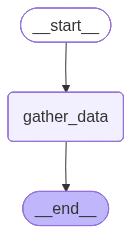

In [8]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class ResearchState(TypedDict):
    research_count: int

def gather_data(state):
    print("---Gathering Data---")
    return {"research_count": state['research_count'] + 1}

# Build graph
builder = StateGraph(ResearchState)
builder.add_node("gather_data", gather_data)

# Logic
builder.add_edge(START, "gather_data")
builder.add_edge("gather_data", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"research_count" : 0})

---Gathering Data---


{'research_count': 1}

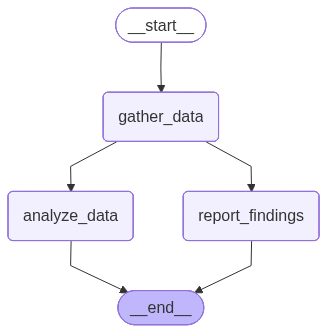

In [10]:
class ResearchState(TypedDict):
    research_count: int

def gather_data(state):
    print("---Gathering Initial Data---")
    return {"research_count": state['research_count'] + 1}

def analyze_data(state):
    print("---Analyzing Data---")
    return {"research_count": state['research_count'] + 1}

def report_findings(state):
    print("---Reporting Findings---")
    return {"research_count": state['research_count'] + 1}

# Build graph
builder = StateGraph(ResearchState)
builder.add_node("gather_data", gather_data)
builder.add_node("analyze_data", analyze_data)
builder.add_node("report_findings", report_findings)

# Logic
builder.add_edge(START, "gather_data")
builder.add_edge("gather_data", "analyze_data")
builder.add_edge("gather_data", "report_findings") # This creates a conflict as both modify research_count
builder.add_edge("analyze_data", END)
builder.add_edge("report_findings", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"research_count" : 0})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Gathering Initial Data---
---Analyzing Data---
---Reporting Findings---
InvalidUpdateError occurred: At key 'research_count': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


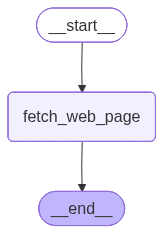

In [13]:

from operator import add
from typing import Annotated
from IPython.display import Image, display 

class ResearchState(TypedDict):
    data_points: Annotated[list[str], add]

def fetch_web_page(state):
    print("---Fetching Web Page---")
    return {"data_points": ["Web page content added"]}

# Build graph
builder = StateGraph(ResearchState)
builder.add_node("fetch_web_page", fetch_web_page)

# Logic
builder.add_edge(START, "fetch_web_page")
builder.add_edge("fetch_web_page", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png())) 

In [14]:
graph.invoke({"data_points" : ["Initial data"]})


---Fetching Web Page---


{'data_points': ['Initial data', 'Web page content added']}

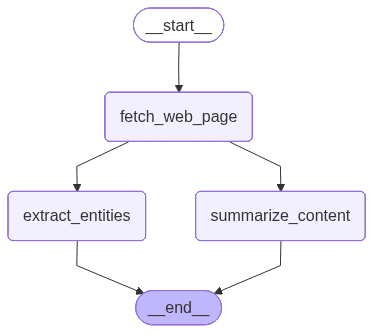

In [15]:
def fetch_web_page(state):
    print("---Fetching Web Page---")
    return {"data_points": [f"Web page {len(state['data_points']) + 1} content"]}

def extract_entities(state):
    print("---Extracting Entities---")
    return {"data_points": [f"Entities from {state['data_points'][-1]}"]}

def summarize_content(state):
    print("---Summarizing Content---")
    return {"data_points": [f"Summary of {state['data_points'][-1]}"]}

# Build graph
builder = StateGraph(ResearchState)
builder.add_node("fetch_web_page", fetch_web_page)
builder.add_node("extract_entities", extract_entities)
builder.add_node("summarize_content", summarize_content)

# Logic
builder.add_edge(START, "fetch_web_page")
builder.add_edge("fetch_web_page", "extract_entities")
builder.add_edge("fetch_web_page", "summarize_content") # This creates a merge point for data_points
builder.add_edge("extract_entities", END)
builder.add_edge("summarize_content", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
graph.invoke({"data_points" : ["Starting document"]})


---Fetching Web Page---
---Extracting Entities---
---Summarizing Content---


{'data_points': ['Starting document',
  'Web page 2 content',
  'Entities from Web page 2 content',
  'Summary of Web page 2 content']}

In [17]:
try:
    graph.invoke({"data_points" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


In [18]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultResearchState(TypedDict):
    data_points: Annotated[list[str], add]

class CustomReducerResearchState(TypedDict):
    data_points: Annotated[list[str], reduce_list]

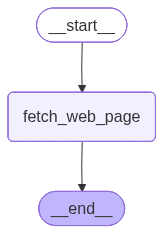

TypeError occurred: can only concatenate list (not "NoneType") to list


In [19]:
def fetch_web_page(state):
    print("---Fetching Web Page---")
    return {"data_points": ["First web page content"]}

# Build graph
builder = StateGraph(DefaultResearchState)
builder.add_node("fetch_web_page", fetch_web_page)

# Logic
builder.add_edge(START, "fetch_web_page")
builder.add_edge("fetch_web_page", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"data_points" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")


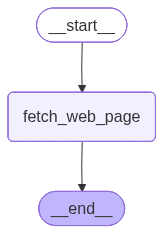

---Fetching Web Page---
{'data_points': ['First web page content']}


In [20]:
builder = StateGraph(CustomReducerResearchState)
builder.add_node("fetch_web_page", fetch_web_page)

# Logic
builder.add_edge(START, "fetch_web_page")
builder.add_edge("fetch_web_page", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

print(graph.invoke({"data_points" : None}))

In [21]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomChatState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_name: str
    session_id: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedChatState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    user_name: str
    session_id: str

In [22]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Greetings! How may I assist you today?", name="AI_Assistant"),
                    HumanMessage(content="I need help with my project on quantum physics.", name="Alice")
                   ]

# New message to add
new_message = AIMessage(content="Quantum physics, a fascinating subject! What aspect are you focusing on?", name="AI_Assistant")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Greetings! How may I assist you today?', additional_kwargs={}, response_metadata={}, name='AI_Assistant', id='d2043f64-327c-4dde-be38-cfbbf53a4e81'),
 HumanMessage(content='I need help with my project on quantum physics.', additional_kwargs={}, response_metadata={}, name='Alice', id='d85b9491-8b5e-4a3f-9e07-28e196fac08c'),
 AIMessage(content='Quantum physics, a fascinating subject! What aspect are you focusing on?', additional_kwargs={}, response_metadata={}, name='AI_Assistant', id='cb468880-7eb6-4d66-9088-1fe46cc3c414')]

In [23]:
initial_messages = [AIMessage(content="Greetings! How may I assist you today?", name="AI_Assistant", id="1"),
                    HumanMessage(content="I need help with my project on quantum physics.", name="Alice", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="Specifically, I'm researching quantum entanglement.", name="Alice", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Greetings! How may I assist you today?', additional_kwargs={}, response_metadata={}, name='AI_Assistant', id='1'),
 HumanMessage(content="Specifically, I'm researching quantum entanglement.", additional_kwargs={}, response_metadata={}, name='Alice', id='2')]

In [24]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi there.", name="Bot", id="1")]
messages.append(HumanMessage("Hello!", name="User", id="2"))
messages.append(AIMessage("I understand you're interested in space exploration?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, particularly the Mars Perseverance rover.", name="User", id="4"))

# Isolate messages to delete (e.g., the first two messages)
delete_messages = [RemoveMessage(id=m.id) for m in messages[:2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [25]:
add_messages(messages , delete_messages)

[AIMessage(content="I understand you're interested in space exploration?", additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, particularly the Mars Perseverance rover.', additional_kwargs={}, response_metadata={}, name='User', id='4')]